<a href="https://colab.research.google.com/github/mannat244/ML_Lab/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CUDA Lab 2

In [34]:
%%writefile addvector.cu
#include <iostream>
#include <cuda_runtime.h>

// GPU kernel
__global__ void addArrays(int *a, int *b, int *c, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        c[i] = a[i] + b[i];
    }
}

// Function that runs GPU code
void addOnGPU(int *h_a, int *h_b, int *h_c, int n) {
    int size = n * sizeof(int);

    int *d_a, *d_b, *d_c;
    cudaMalloc(&d_a, size);
    cudaMalloc(&d_b, size);
    cudaMalloc(&d_c, size);

    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    int threads = 256;
    int blocks = (n + threads - 1) / threads;

    cudaEventRecord(start);
    addArrays<<<blocks, threads>>>(d_a, d_b, d_c, n);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float time_ms;
    cudaEventElapsedTime(&time_ms, start, stop);

    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

    std::cout << "GPU time (ms): " << time_ms << "\n";

    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
}

int main() {
    int n = 50000;   // fixed size for simplicity

    int *a = new int[n];
    int *b = new int[n];
    int *c = new int[n];

    for (int i = 0; i < n; i++) {
        a[i] = 5;
        b[i] = 2;
    }

    addOnGPU(a, b, c, n);

    std::cout << "Sample output: " << c[0] << "\n";

    delete[] a;
    delete[] b;
    delete[] c;

    return 0;
}


Overwriting addvector.cu


In [35]:
!nvcc -o addvector addvector.cu -arch=sm_75

In [40]:
!./addvector

GPU time (ms): 0.09472
Sample output: 7


In [37]:
%%writefile addcpu.cpp
#include <iostream>
#include <chrono>

using namespace std;

// Function that runs on CPU
void addOnCPU(int *a, int *b, int *c, int n) {
    for (int i = 0; i < n; i++) {
        c[i] = a[i] + b[i];
    }
}

int main() {
    int n = 50000;

    int *a = new int[n];
    int *b = new int[n];
    int *c = new int[n];

    // Prefill arrays
    for (int i = 0; i < n; i++) {
        a[i] = 5;
        b[i] = 2;
    }

    // Start timer
    auto start = chrono::high_resolution_clock::now();

    addOnCPU(a, b, c, n);

    // Stop timer
    auto end = chrono::high_resolution_clock::now();

    double time_ms =
        chrono::duration<double, milli>(end - start).count();

    cout << "CPU time (ms): " << time_ms << endl;
    cout << "Sample output: " << c[0] << endl;

    delete[] a;
    delete[] b;
    delete[] c;

    return 0;
}


Overwriting addcpu.cpp


In [41]:
!g++ addcpu.cpp -O2 -o addcpu
!./addcpu


CPU time (ms): 0.110685
Sample output: 7


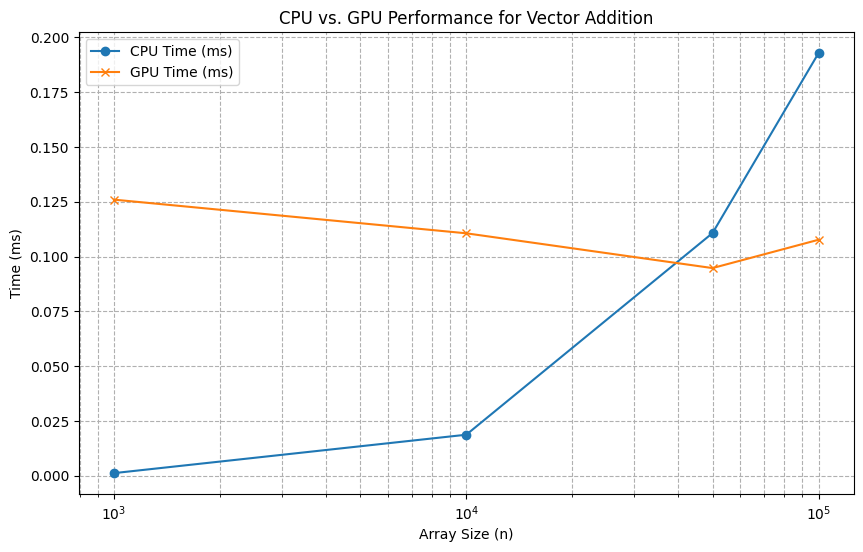

In [42]:
import matplotlib.pyplot as plt

n_values = [1000, 10000, 50000, 100000]
cpu_times = [0.001154, 0.018679, 0.110685, 0.192813]
gpu_times = [0.125952, 0.110592, 0.094720, 0.107648]

plt.figure(figsize=(10, 6))
plt.plot(n_values, cpu_times, marker='o', label='CPU Time (ms)')
plt.plot(n_values, gpu_times, marker='x', label='GPU Time (ms)')

plt.xscale('log')
plt.xlabel('Array Size (n)')
plt.ylabel('Time (ms)')
plt.title('CPU vs. GPU Performance for Vector Addition')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()